<a href="https://colab.research.google.com/github/chenzhaoqi718/test/blob/main/LSTM/lstm_sale_new_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
file_path = '/content/drive/MyDrive/group/rossmann_normalized.csv'
df = pd.read_csv(file_path)
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,lag_1,lag_7,rolling_mean_7,rolling_std_7,Sales_normalized,lag_1_normalized,lag_7_normalized,rolling_mean_7_normalized,rolling_std_7_normalized,CompetitionDistance_normalized
0,2,2,2013-01-08,6318,685,1,1,0,0,a,...,6775.0,0.0,3168.857143,2518.320236,0.167827,0.179966,0.000000,0.140882,0.183338,0.019521
1,2,3,2013-01-09,6763,785,1,1,0,0,a,...,6318.0,4422.0,4071.428571,2317.492169,0.179647,0.167827,0.117463,0.181009,0.168718,0.019521
2,2,4,2013-01-10,5618,637,1,1,0,0,a,...,6763.0,4159.0,4405.857143,2535.198180,0.149232,0.179647,0.110477,0.195877,0.184567,0.019521
3,2,5,2013-01-11,4810,539,1,1,0,0,a,...,5618.0,4484.0,4614.285714,2571.239436,0.127769,0.149232,0.119110,0.205143,0.187191,0.019521
4,2,6,2013-01-12,2630,337,1,0,0,0,a,...,4810.0,2342.0,4660.857143,2571.438665,0.069861,0.127769,0.062211,0.207214,0.187206,0.019521


In [ ]:
df.shape

(321771, 34)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
7240/7240 ━━━━━━━━━━━━━━━━━━━━ 477s 65ms/step - loss: 0.0055 - mae: 0.0544 - val_loss: 0.0068 - val_mae: 0.0598
Epoch 2/50
7240/7240 ━━━━━━━━━━━━━━━━━━━━ 492s 64ms/step - loss: 0.0047 - mae: 0.0489 - val_loss: 0.0064 - val_mae: 0.0583
Epoch 3/50
7240/7240 ━━━━━━━━━━━━━━━━━━━━ 497s 63ms/step - loss: 0.0045 - mae: 0.0477 - val_loss: 0.0061 - val_mae: 0.0552
Epoch 4/50
7240/7240 ━━━━━━━━━━━━━━━━━━━━ 506s 64ms/step - loss: 0.0044 - mae: 0.0467 - val_loss: 0.0065 - val_mae: 0.0565
Epoch 5/50
7240/7240 ━━━━━━━━━━━━━━━━━━━━ 502s 64ms/step - loss: 0.0043 - mae: 0.0461 - val_loss: 0.0056 - val_mae: 0.0528
Epoch 6/50
7240/7240 ━━━━━━━━━━━━━━━━━━━━ 511s 65ms/step - loss: 0.0041 - mae: 0.0449 - val_loss: 0.0056 - val_mae: 0.0529
Epoch 7/50
7240/7240 ━━━━━━━━━━━━━━━━━━━━ 478s 66ms/step - loss: 0.0041 - mae: 0.0446 - val_loss: 0.0060 - val_mae: 0.0537
Epoch 8/50
7240/7240 ━━━━━━━━━━━━━━━━━━━━ 488s 64ms/step - loss: 0.0040 - mae: 0.0441 - val_loss: 0.0053 - val_mae: 0.0510
Epoch 9/50
7240/

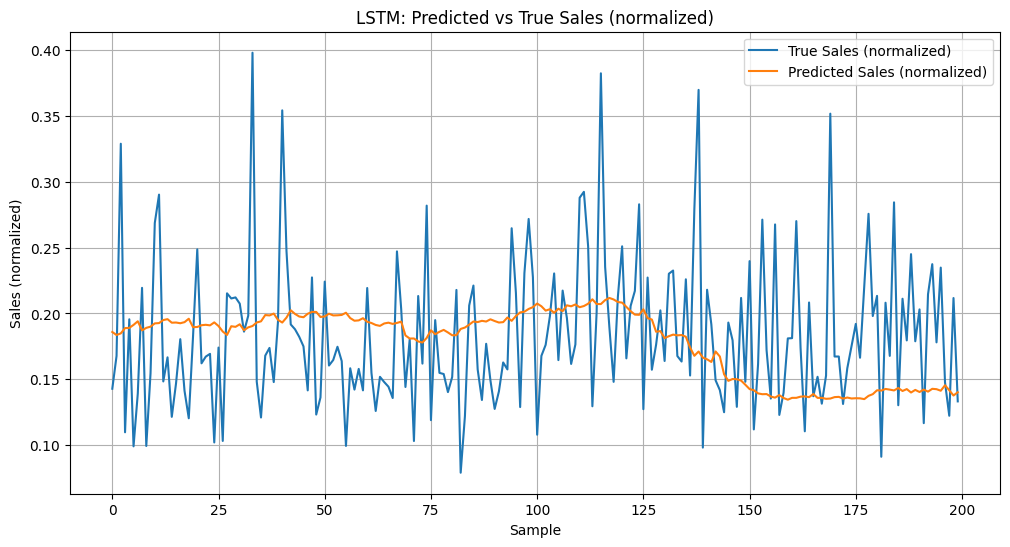

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Convert the 'Date' column to datetime format and sort the DataFrame by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Select all normalized features except the target 'Sales_normalized'
feature_cols = [col for col in df.columns if col.endswith('_normalized') and col != 'Sales_normalized']
target_col = 'Sales_normalized'

# Prepare the model input DataFrame and drop missing values
df_model = df[feature_cols + [target_col]].dropna().copy()

# Function to create input sequences for LSTM
def create_sequences(X, y, seq_length=28):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])  # A sequence of `seq_length` timesteps
        ys.append(y[i+seq_length])    # Target is the value right after the sequence
    return np.array(Xs), np.array(ys)

# Extract input and target values, then create LSTM sequences
X_all = df_model[feature_cols].values
y_all = df_model[target_col].values
X_seq, y_seq = create_sequences(X_all, y_all, seq_length=28)

# Split the data into training and testing sets (no shuffle to preserve time order)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1))  # Single output for regression
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Define early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Predict on the test set
y_pred = model.predict(X_test)

# Plot the comparison of predicted vs true normalized sales
plt.figure(figsize=(12, 6))
plt.plot(y_test[:200], label='True Sales (normalized)')
plt.plot(y_pred[:200], label='Predicted Sales (normalized)')
plt.title('LSTM: Predicted vs True Sales (normalized)')
plt.xlabel('Sample')
plt.ylabel('Sales (normalized)')
plt.legend()
plt.grid(True)
plt.show()

2011/2011 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 0.0038 - mae: 0.0422
Test MAE (scaled): 0.0441
2011/2011 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step


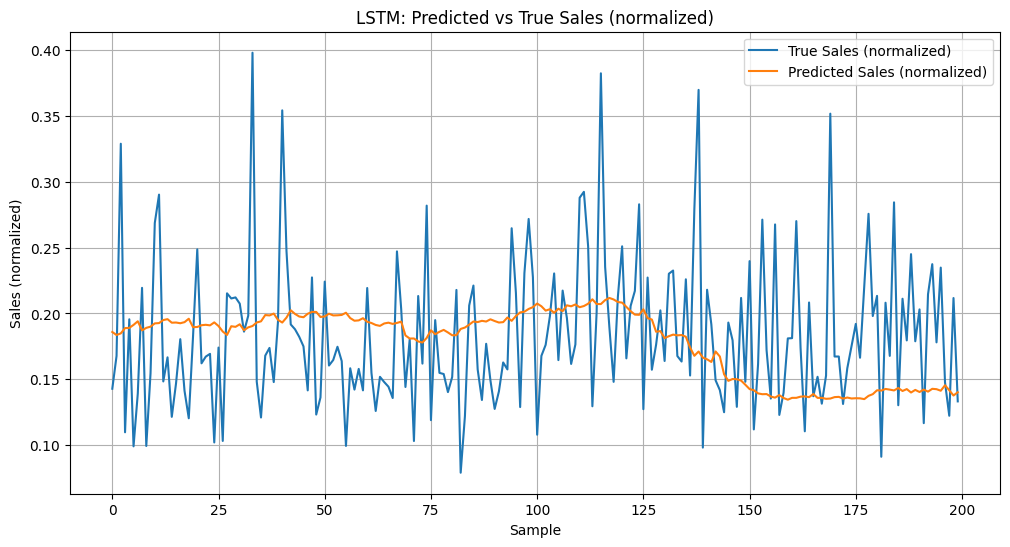

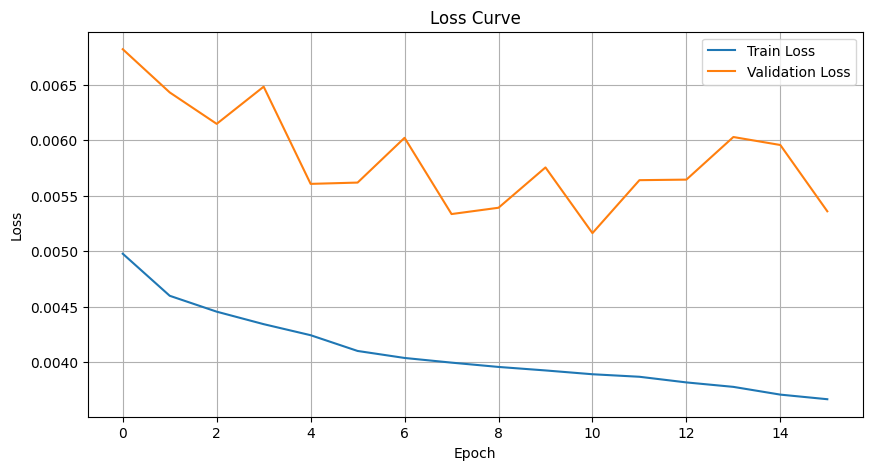

In [ ]:

loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE (scaled): {mae:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

